<a href="https://colab.research.google.com/github/predictions01/zabbix/blob/main/predictions_multi_macchina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install lime shap eli5

In [3]:
%run drive/MyDrive/colab_Notebooks/librerie/AJ_draw.py
%run drive/MyDrive/colab_Notebooks/librerie/AJ_ML_eda.py
%run drive/MyDrive/colab_Notebooks/librerie/AJ_models_classifier.py

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [5]:
main_folder = 'drive/MyDrive/Dati/'
metrics = pd.read_pickle(main_folder+"zabbix_AJ")
tickets = pd.read_pickle(main_folder+"tickets_AJ")

In [6]:
def single_dev_prep(df_metrics, df_tickets, dev, hours_pre_event, hour_post_event):
  my_metrics = df_metrics[df_metrics.device == dev].set_index('timestamp')[['metric', 'value']]
  df = my_metrics.pivot(columns='metric', values='value').dropna(thresh=my_metrics.index.nunique() * .9, axis=1).interpolate(limit_direction='both')
  df['hour'] = df.index.hour
  df['day'] = df.index.dayofweek
  df['week'] = df.index.isocalendar().week
  
  # selezioni macchina
  my_tickets = df_tickets[df_tickets['device'] == dev].set_index('timestamp')
  
  #crei la colonna dei target e droppi tutte le altre
  col_my_tickets = my_tickets.columns.tolist()
  my_tickets['y'] = 1
  my_tickets = my_tickets.drop(col_my_tickets, axis=1).reset_index()

  # arrotondi i tickets all'ora piu vicina
  my_tickets['timestamp'] = my_tickets['timestamp'].dt.round(freq = '1h')
  df = df.reset_index()

  #mergi i target con il df
  df = pd.merge(df, my_tickets, on = 'timestamp', how = 'outer')
  df['y'] = df['y'].fillna(0)

  #creo un indice dei tempi a cui si presentano i tickets a cui aggiungo il primo e l'ultimo evento del df
  vet_tickets_times = my_tickets['timestamp'].sort_values().tolist()
  vet_tickets_times = [df.iloc[0]['timestamp']] + vet_tickets_times + [df.iloc[-1]['timestamp']]

  #creo una colonna con la data dell'ultimo ticket aperto
  df_last_event = pd.DataFrame()
  for i in range(len(vet_tickets_times)-1):
      df_temp = pd.DataFrame()
      # df_temp = df[df['timestamp'] >= vet_tickets_times[i] ][ df['timestamp'] < vet_tickets_times[i+1]]
      df_temp = df[df['timestamp'] >= vet_tickets_times[i]]
      df_temp = df_temp[df_temp['timestamp'] < vet_tickets_times[i+1]]
      df_temp['last_event_time'] = vet_tickets_times[i]
      df_last_event = pd.concat([df_last_event, df_temp])
      del df_temp

  #converto la data dell'ultimo ticket in numero di ore dall'ultimo ticket
  df_last_event = pd.DataFrame(df_last_event.iloc[:]['last_event_time'])
  df_last_event = pd.concat([df_last_event, pd.DataFrame([df_last_event.iloc[df_last_event.shape[0] - 1]['last_event_time']], columns = ['last_event_time'])])
  df['last_event_time'] = df_last_event.values
  df['last_event_delay'] = ((df['timestamp'] - df['last_event_time'])/np.timedelta64(1,'h')).astype(int)
  df = df.drop('last_event_time', axis = 1)

  df.set_index('timestamp', inplace=True)
  
  #funzione per mettere il label del ticket anche ad date successive o precedenti
  def increase_events_calculator(df, hours, direction = 1):
      hours = hours + 1
      for i in range(1,hours):
          df['y'+str(i)] = df['y'].shift(i*direction)

      for i in range(1,hours):
          df['y'] = df['y']+df['y'+str(i)]

      df['y'] = df['y'].fillna(0)
      dropy = ['y'+str(i) for i in range(1,hours)]
      df = df.drop(dropy, axis = 1)
      return df

  #aumento il numenro di label che rappresentano l'apertura del ticket
  df = increase_events_calculator(df, hour_post_event)
  df = increase_events_calculator(df, hours_pre_event, direction = -1)

  # le funzioni sopra creano creano numeri superiori a 1, ritrasforno tutto quello che e' superiore a 1 in 1
  df['y'] = df['y'].replace([i for i in range(1,int(df['y'].max()+1))], 1).astype(int)

  #scopro quali sono le metriche che correlano tra se stesse piu del 95% e le droppo
  _, correlation_within_features = learning(df).correlation_matrix('y', corr_value_w_targhet = 0.05, plot_matr = 'no')
  df = df.drop(correlation_within_features, axis = 1)

  #delle metriche rimaste scopro quali correlano con il target meno del 5% e le droppo
  correlation_with_target, _ = learning(df).correlation_matrix('y', corr_value_w_targhet = 0.05, plot_matr = 'no')
  df = df.drop(correlation_with_target.index.tolist(), axis = 1)
  return df

In [7]:
def preprocess_data_on_each_device(hours_pre_event, hour_post_event):
  metrics_x_device = dict()
  devices = metrics['device'].unique().tolist()
  for dev in devices:
    metrics_x_device[dev] = single_dev_prep(metrics, tickets, dev, hours_pre_event, hour_post_event)
  return metrics_x_device, devices

In [8]:
def device_metrics_selection(metrics_x_device, devices):
  # estrae le metriche presenti in ogni device
  list_cols = pd.DataFrame()
  for dev in devices:
    list_cols[dev] = [metrics_x_device[dev].columns.tolist()]

  # mette tutte le metriche di ogni device in un vettore flat
  List_flat = []
  for i in range(list_cols.shape[1]):
    dev = list_cols.columns.tolist()[i]
    for j in range (len(list_cols.iloc[0][dev])):
      List_flat.append(list_cols.iloc[0][dev][j])

  # trova quali sono le metriche uniche
  df_List_flat = pd.DataFrame(List_flat)
  unique_list = df_List_flat[0].unique()
  df_counter = pd.DataFrame()
  element = unique_list[0]

  #confronta quante volte ogni metrica si presenta in ogni device
  for element in unique_list:
    count = 0
    for dev in list_cols.columns:
      list_dev = list_cols.iloc[0][dev]
      if element in list_dev:
        count = count + 1
    df_counter[element] = [count]

  # seleziona le prime 5 metriche piu usate
  vect_counter = df_counter.T[0].sort_values(ascending = False)[:5]
  # print(vect_counter)

  # seleziona i device che posseggono tutte e 5 le metriche piu usate
  list_dev = list_cols.columns
  for j in vect_counter.index:
    count = 0
    devs = []
    for dev in list_dev:
      list_metric = list_cols.iloc[0][dev]
      for i in list_metric:
        if i == j:
          count = count + 1
          devs.append(dev)
    list_dev = devs
    # print(count)
    # print(devs)
  return devs, vect_counter

In [9]:
def normalization_train_test(num_hours, devs, metrics_x_device, vect_counter):
  # unisce i df di ogni device preprocessato in un unico df globale
  df_global = pd.DataFrame()
  for dev in devs:
    df_w_device = metrics_x_device[dev].loc[:,vect_counter.index]
    df_w_device['device'] = dev
    df_global = pd.concat([df_global, df_w_device])

  # separa la y dalle X e i device
  df_y = df_global.loc[:,'y']
  df_device = df_global.loc[:,'device']
  df_global = df_global.drop(['y', 'device'], axis = 1)
  df_col = df_global.columns
  df_index = df_global.index

  # converte i device in numeri
  df_device, device_dict = learning().convertIntoNumbers(pd.DataFrame(df_device, columns = ['device']), 'device', dictionary = 'yes')

  # normalizzo le metriche
  scaler = StandardScaler()
  df_global = scaler.fit_transform(df_global)
  df_global = pd.DataFrame(df_global, index = df_index, columns = df_col)
  df_global['device'] = df_device['device']

  # per ogni metrica che non sia y, settimane, giorni o delay viene creata la sequenza temporare, diviso per device
  for lag in range(1,num_hours):
    for j in vect_counter.index:
      if j != 'y' and j != 'day' and j != 'week' and j != 'last_event_delay':
        df_global[j+'_'+str(lag)+'_hours_back'] = df_global[["device",j]].groupby("device")[j].shift(lag)
 
  # si reordinano le metriche cosi da avere le sequenze temporali vicine
  new_col = []
  for col in df_col:
      new_col.append(col)
      if col != 'y' and col != 'day' and col != 'week' and col != 'last_event_delay':
        for i in range(1,num_hours):
            new_col.append(col+'_'+str(i)+'_hours_back')
  new_col.append('device')
  df_global = df_global[new_col]

  # si reinserisce la y e si scartano i nan
  df_global['y'] = df_y
  df_global = df_global.dropna()

  #elimino alcune lettere che danno noia a xgboost
  import re
  regex = re.compile(r"\[|\]|<", re.IGNORECASE)
  df_global.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_global.columns.values]

  training_set_global = pd.DataFrame()
  test_set_global = pd.DataFrame()

  #splitto un device per volta senza shaffle per mantenere l'ordine temporale
  for i in df_global['device'].unique():
    training_set_temp, test_set_temp = train_test_split(df_global[df_global['device'] == i], test_size=0.3, shuffle=False)
    training_set_global = pd.concat([training_set_global, training_set_temp])
    test_set_global = pd.concat([test_set_global, test_set_temp])

  return training_set_global, test_set_global

In [10]:
def working_function(df_train, df_test, verbose = 0):
  #scelgo i modelli da usare
  learn = learning_class()
  # models = learn.get_models(['RandomForestClassifier', 'XGBClassifier'])

  models = learn.get_models(['RandomForestClassifier', 'XGBClassifier', 'KNeighborsClassifier', 'SVC', 'ExtraTreeClassifier', 'LogisticRegression'])
  normal, sparse = 'normal', 'sparse'
  models['deep learning ' + normal +' '+ sparse] = learn.get_deep_learning_model(input_dl = df_train.loc[:, df_train.columns != 'y'].shape[1],net_type = normal, loss_type = sparse)

  #training, test and score
  models, _ = learn.train_models(models, df_train.loc[:, df_train.columns != 'y'], df_train.y, shuffle = False, epochs = 10)
  prob, pred = learn.prob_matrix_generator(models, df_test.loc[:, df_test.columns != 'y'], num_classes=2)
  score = learn.score_models(df_test.y, prob, pred)
  if verbose == 1:
    print(score)

  if verbose == 1:
    # plot le roc curve
    learn.plot_roc_curve(prob, df_test.y)
 
  # plot le confusion matrix
  conf_matr = learn.score_accuracy_recall(pred, df_test.y, verbose = verbose)

  #leggi i valori sulla confusion matrix per estrappolare le metriche di scoring
  df_score = pd.DataFrame()
  for model in list(models.keys()) + ['Ensamble']:
      df_score[model] = [learn.confusion_matrix_dict[model].loc['True 1','Predict 1']/learn.confusion_matrix_dict[model].loc['True 1','tot true']]

  #essendo un problema sbilanciato controllo l'accuratezza sul trovare correttamente gli 1
  df_score = df_score.T
  df_score.columns = ['Accuracy on predicting 1']
  if verbose == 1:
    print(df_score)
  return df_score


In [11]:
def main_job(num_hours, hours_pre_event, hour_post_event):
  metrics_x_device, devices = preprocess_data_on_each_device(hours_pre_event, hour_post_event)
  devs, vect_counter = device_metrics_selection(metrics_x_device, devices)
  training_set_global, test_set_global = normalization_train_test(num_hours, devs, metrics_x_device, vect_counter)
  score = working_function(training_set_global, test_set_global)
  return score

In [12]:
max_target = 15
max_delay = 13
dict_score_x_model = dict()
for target in range(1,max_target):# di quante ore prima salvare le info delle metriche
  score_vet = []
  for delay in range(1,max_delay):# su quante ore spalmare gli 1 della y
    score = main_job(delay, target, 0)
    dict_score_x_model[str(target) +' '+ str(delay)] = score
    print('target '+str(target) +', delay'+ str(delay))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay3



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay4



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 1, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay3



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 2, delay11



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoi

target 2, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay2



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay3



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay10



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 3, delay12



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoi

target 4, delay1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 4, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay4



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay5



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay7



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay8



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay10



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 5, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay3



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 6, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay4



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay6



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 7, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 8, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 9, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 10, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 11, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 12, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 13, delay12


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay1


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay2


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay3


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay4


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay5


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay6


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay7


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay8


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay9


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay10


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay11


`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


target 14, delay12


In [13]:
models = dict_score_x_model[str(1) +' '+ str(1)].index
score_index = dict()

for model in models:
  models_score = pd.DataFrame()
  for target in range(1,max_target):
    vet_model = []
    delay_index = []
    for delay in range(1,max_delay):
      delay_index.append('delay '+str(delay))
      vet_model.append(dict_score_x_model[str(target) +' '+ str(delay)].loc[model,'Accuracy on predicting 1'])
    models_score['target '+str(target)] = vet_model
  models_score.index = delay_index
  score_index[model] = models_score

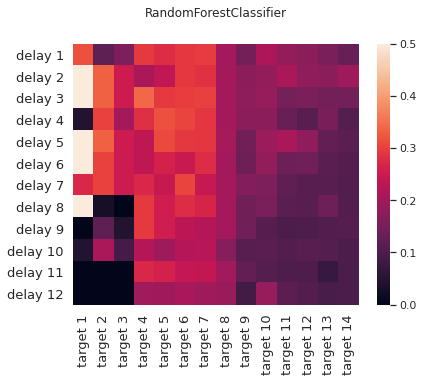

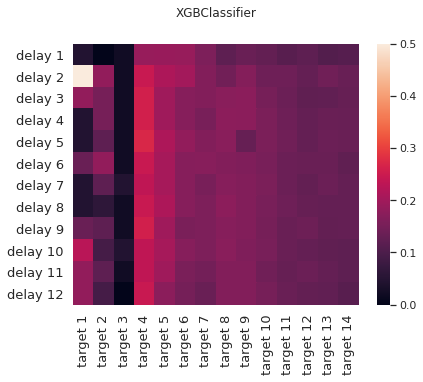

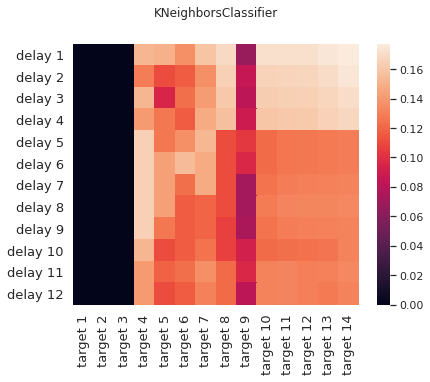

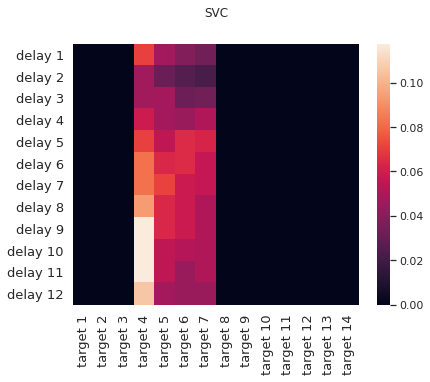

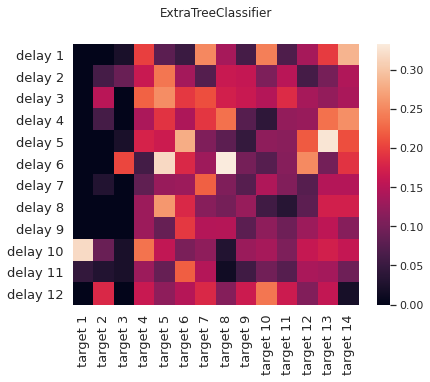

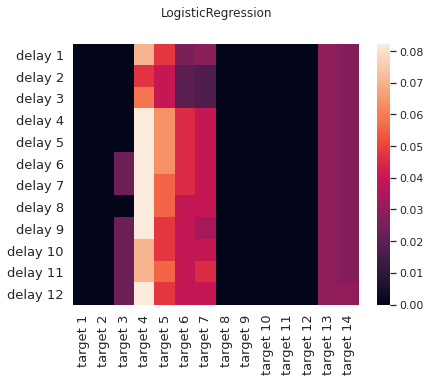

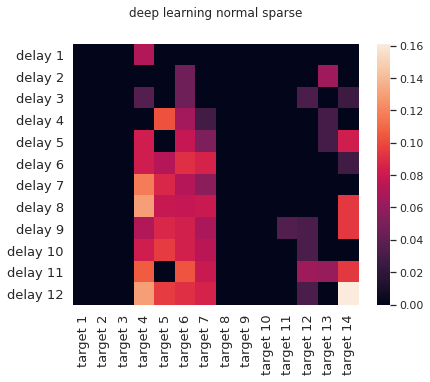

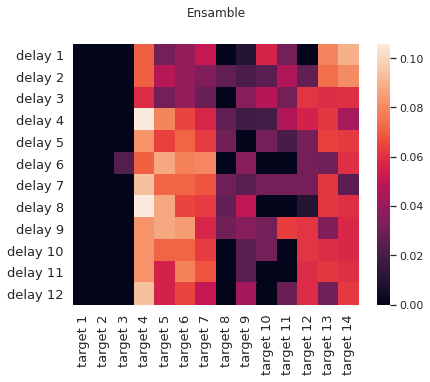

In [14]:
import seaborn as sns; sns.set_theme()
for i,model in enumerate(models):
  ds().nuova_fig(i)
  ds().titoli(titolo = model)
  sns.heatmap(score_index[model])